In [3]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 2.7 MB/s eta 0:00:00


In [4]:
import FinanceDataReader as fdr

# 삼성전자

In [ ]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2024-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-10,87600,88000,87100,87800,17813847,0.000000
2024-07-11,88500,88800,86700,87600,24677608,-0.002278
2024-07-12,85900,86100,84100,84400,26344386,-0.036530
2024-07-15,84700,87300,84100,86700,25193080,0.027251
2024-07-16,86900,88000,86700,87700,16038408,0.011534


- 오늘(24.7.16)까지 데이터

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617
2023-01-03,55400,56000,54500,55400,13547030,-0.001802
2023-01-04,55700,58000,55600,57800,20188071,0.043321
2023-01-05,58200,58800,57600,58200,15682826,0.006920
2023-01-06,58300,59400,57900,59000,17334989,0.013746


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2023-01-02 to 2024-07-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    378 non-null    int64  
 1   High    378 non-null    int64  
 2   Low     378 non-null    int64  
 3   Close   378 non-null    int64  
 4   Volume  378 non-null    int64  
 5   Change  378 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 20.7 KB


- num of rows = 378

- 간단한 column info
  - Open: 시가
  - High: 당일 최고가
  - Low: 당일 최저가
  - Close: 종가
  - Volumne: 거래량
  - Change: 종가 기준 전일 대비 가격 변동률

# 분석 코드

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

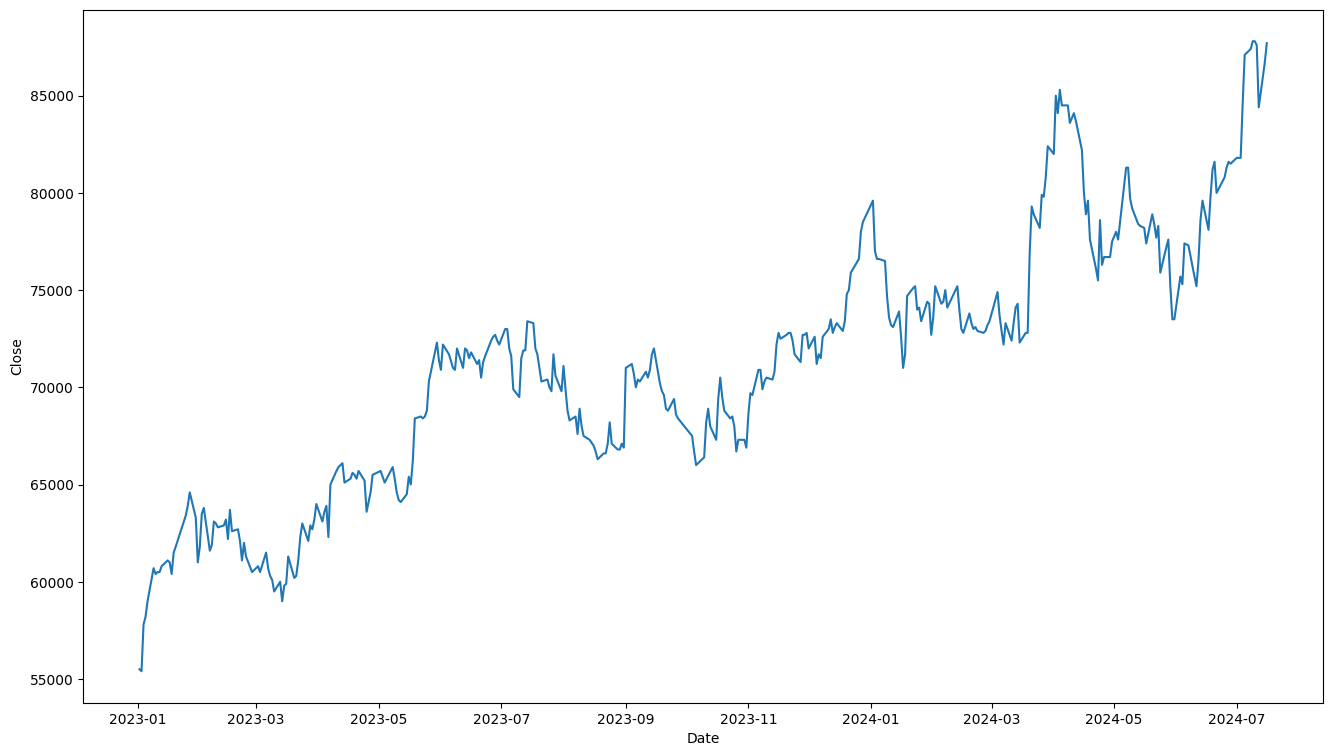

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

- 상승 추세 (역시,,

# 데이터 전처리

In [ ]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-12-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([173, 5, 4]) torch.Size([173, 1])


In [ ]:
x_train_seq

tensor([[[0.0030, 0.0030, 0.0215, 0.0811],
         [0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219]],

        [[0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471]],

        [[0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742]],

        ...,

        [[0.4018, 0.3994, 0.4202, 0.1119],
         [0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742, 0.1869],
         [0.3535, 0.3445, 0.3742, 0.1062]],

        [[0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742

In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

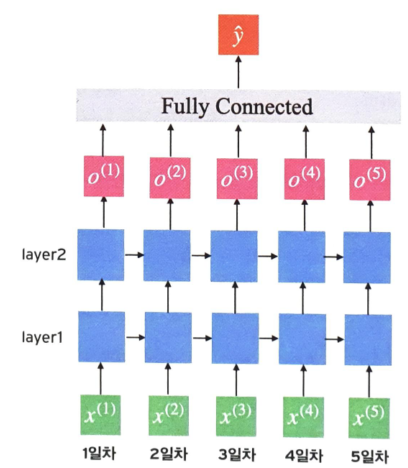

In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0260
[epoch : 10] loss: 0.0020
[epoch : 20] loss: 0.0019
[epoch : 30] loss: 0.0017
[epoch : 40] loss: 0.0016


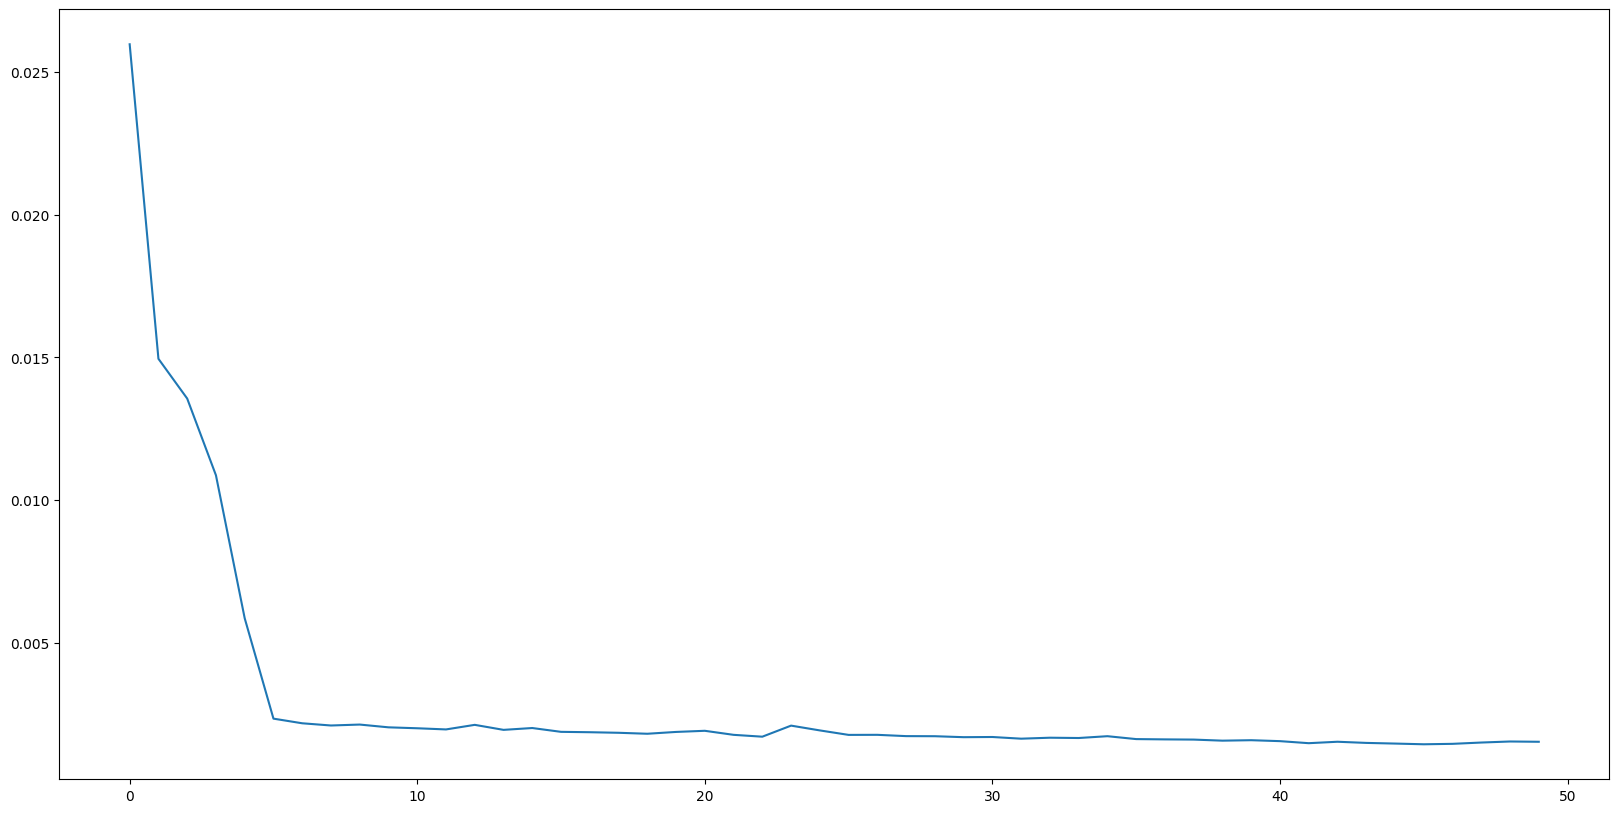

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

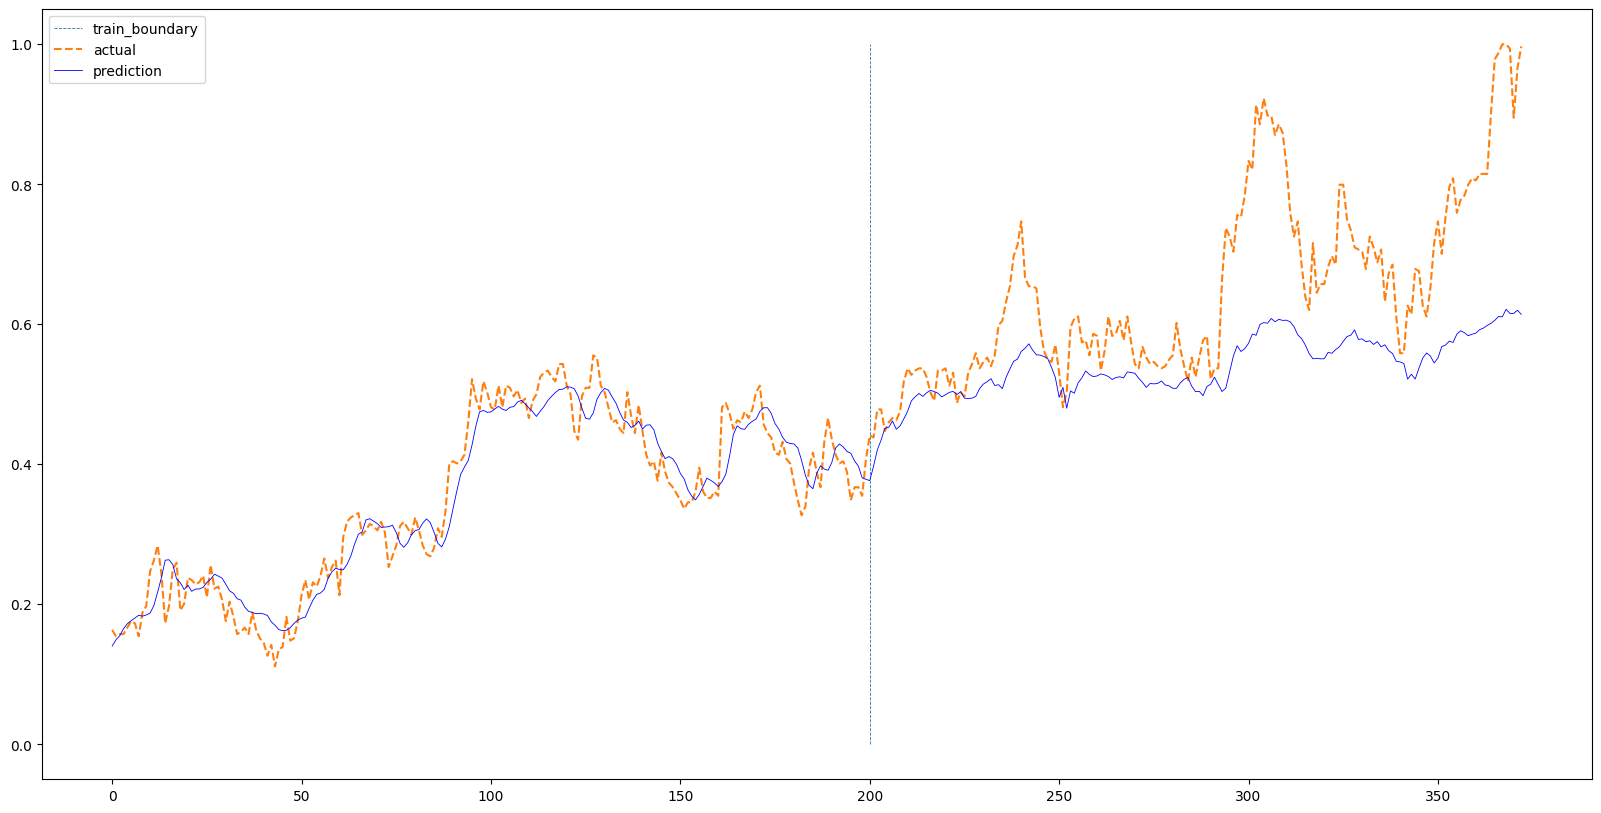

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

- 정확한 값과는 차이가 있지만 대략적인 추세(올라가는 지점, 떨어지는 지점)는 예측함

# LSTM
## 모델구축

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0578
[epoch: 10] loss: 0.0019
[epoch: 20] loss: 0.0018
[epoch: 30] loss: 0.0017
[epoch: 40] loss: 0.0016


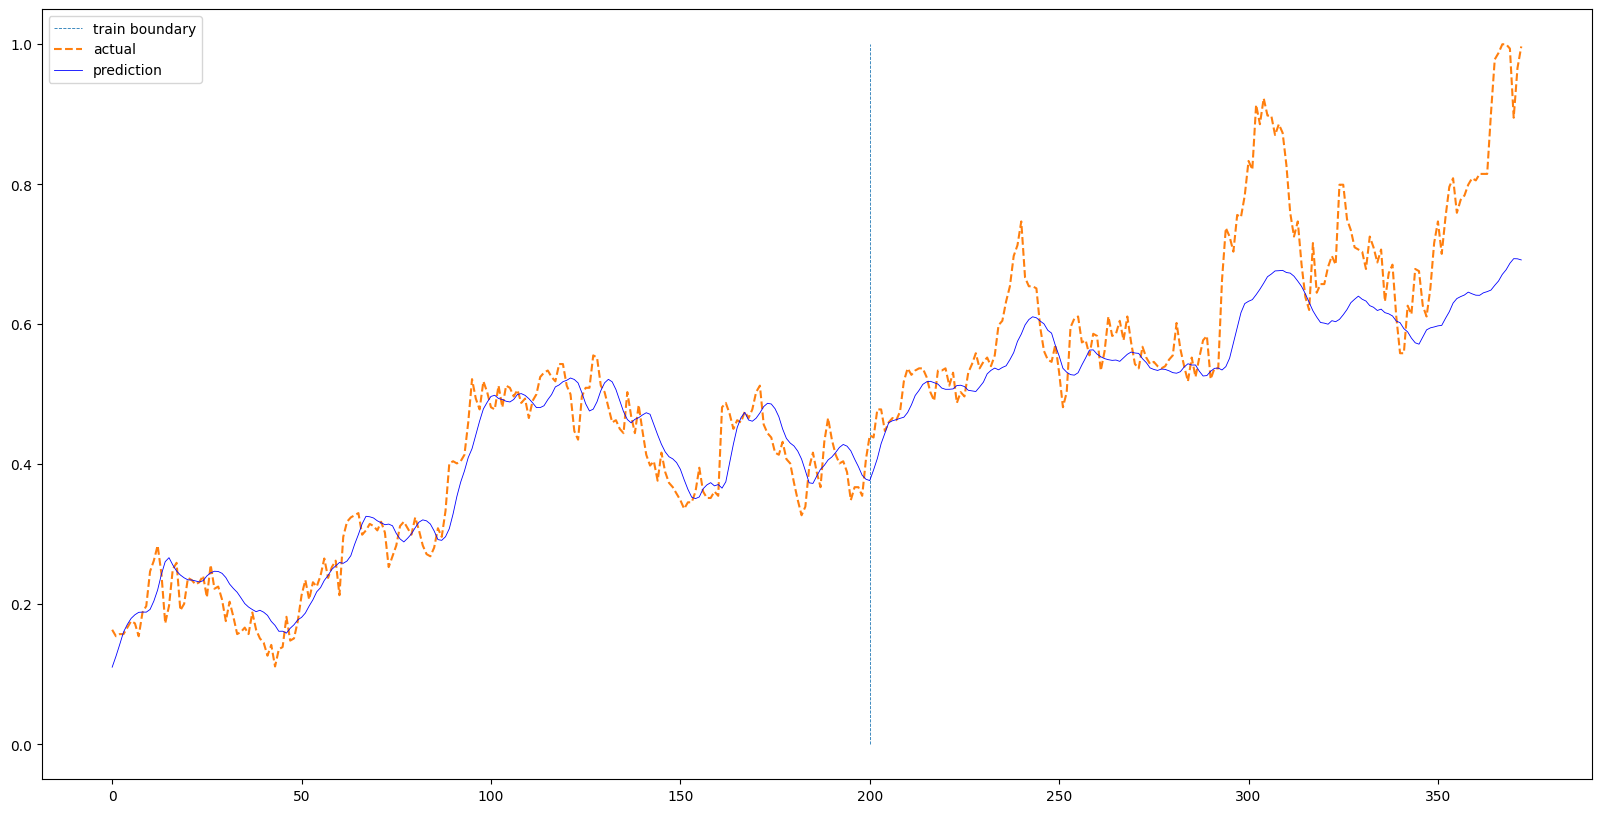

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

- 정확한 값에는 RNN보다 조금 더 가깝게 예측한 것 같은데, 디테일한 추세는 잡아내지 못하는 듯

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

구분을 위해 코드 복붙함..:))

In [8]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2023-01-02  154000  161000  154000  157000  1132256  0.039735
2023-01-03  158500  160500  156000  159000   787752  0.012739
2023-01-04  157500  161000  157500  160500   463444  0.009434
2023-01-05  161000  161500  158000  159000   577152 -0.009346
2023-01-06  157500  161500  157500  159500   502420  0.003145
...            ...     ...     ...     ...      ...       ...
2024-07-11  277000  278500  274500  278500   653458  0.014572
2024-07-12  277500  278500  268000  271500   666813 -0.025135
2024-07-15  273000  273500  267500  268500   541442 -0.011050
2024-07-16  270500  276000  270000  274500   552065  0.022346
2024-07-17  275500  275500  269000  269500   243195 -0.018215

[379 rows x 6 columns]>

In [9]:
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-11,277000,278500,274500,278500,653458,0.014572
2024-07-12,277500,278500,268000,271500,666813,-0.025135
2024-07-15,273000,273500,267500,268500,541442,-0.011050
2024-07-16,270500,276000,270000,274500,552065,0.022346
2024-07-17,275500,275500,269000,269500,243195,-0.018215


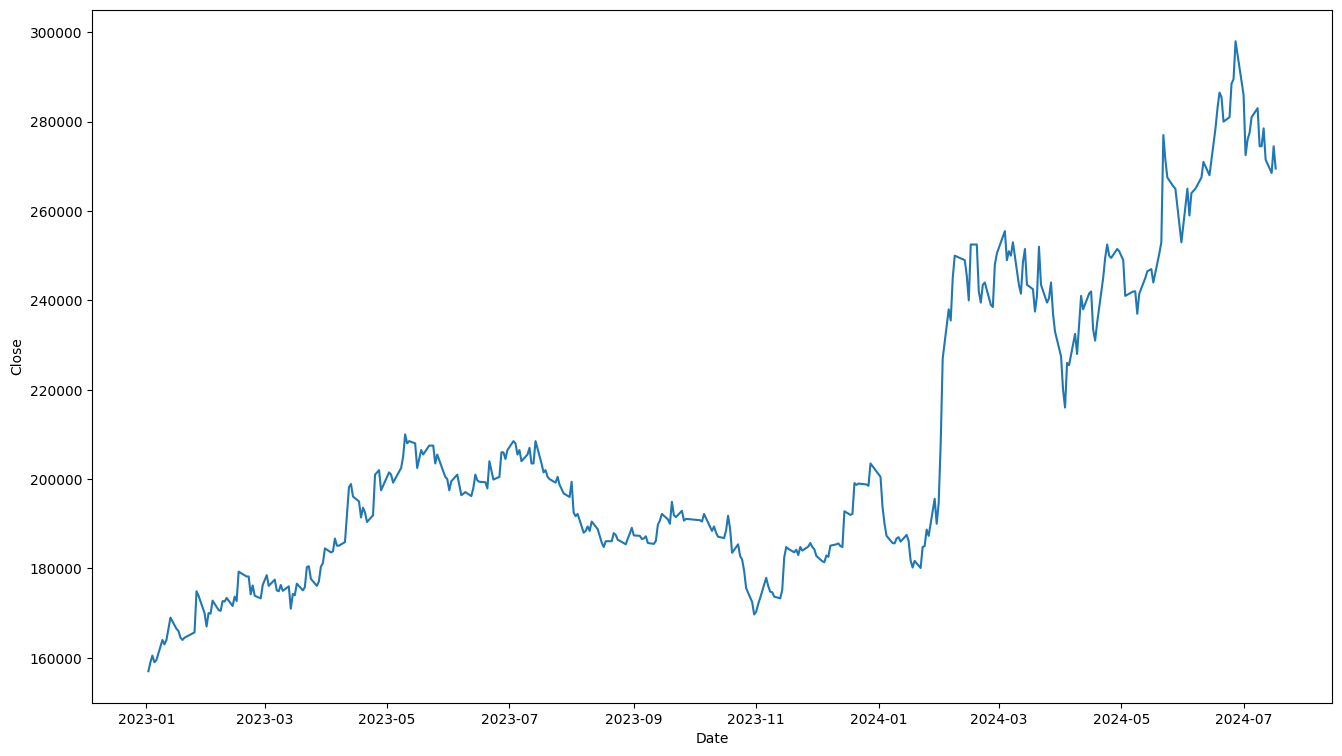

In [10]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

- 2024년 이전에는 증가했다가 다소 감소하는 추세
- 2024년 이전 데이터로 2024년 이후에 급증하는 추세 및 값을 예측할 수 있을 것인가!

In [11]:
# Preprocessing
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

split = 200
sequence_length=5
x_seq, y_seq = seq_data(x, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

<ipython-input-11-cabcc47c0350>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [12]:
# Vanila RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))


[epoch : 0] loss: 0.0335
[epoch : 10] loss: 0.0011
[epoch : 20] loss: 0.0009
[epoch : 30] loss: 0.0009
[epoch : 40] loss: 0.0008


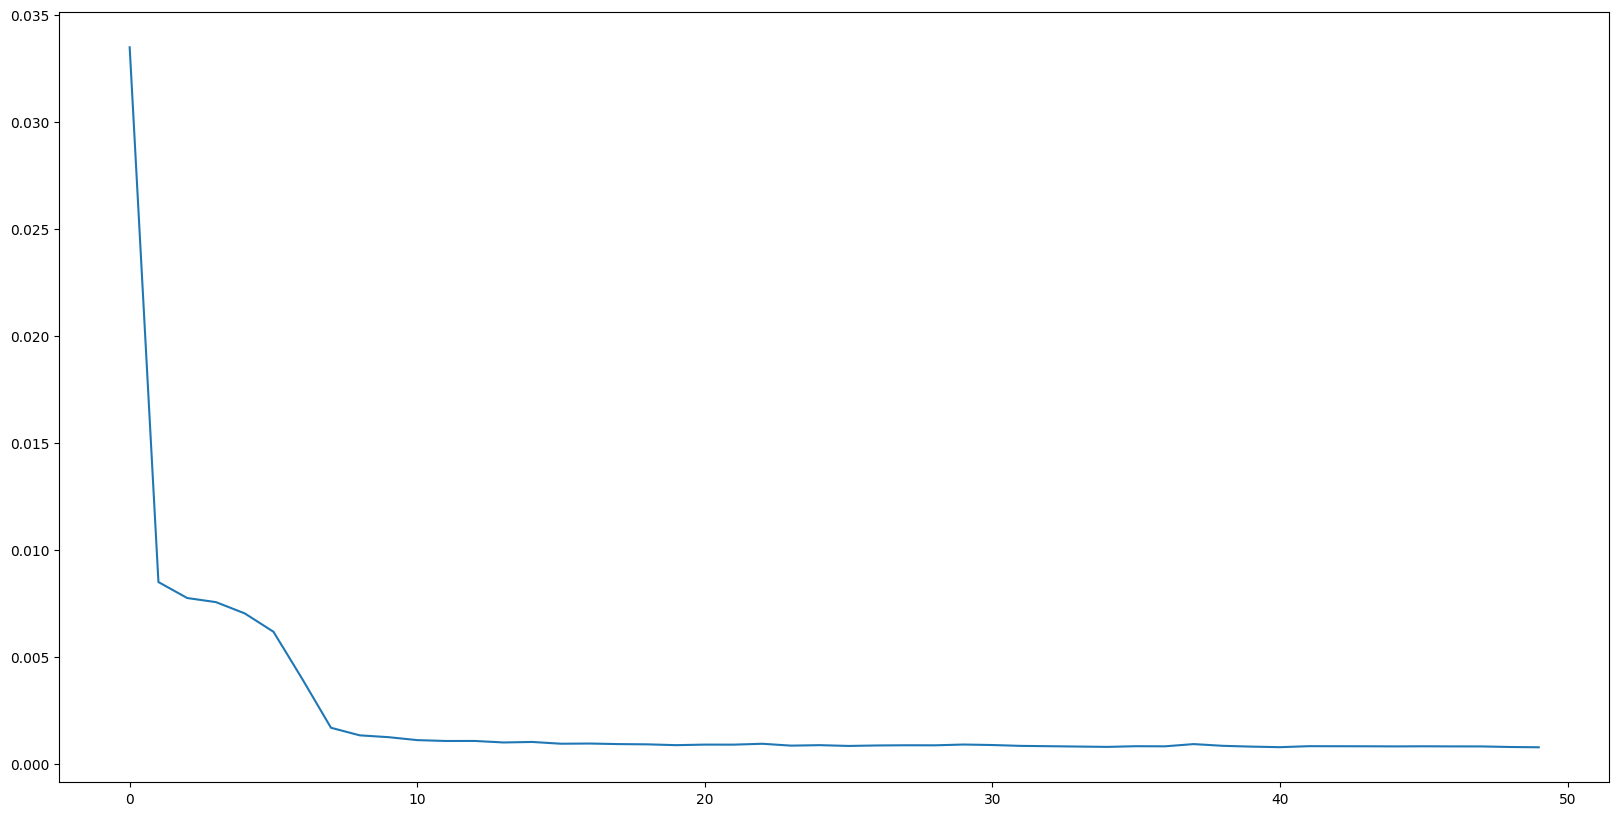

In [13]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

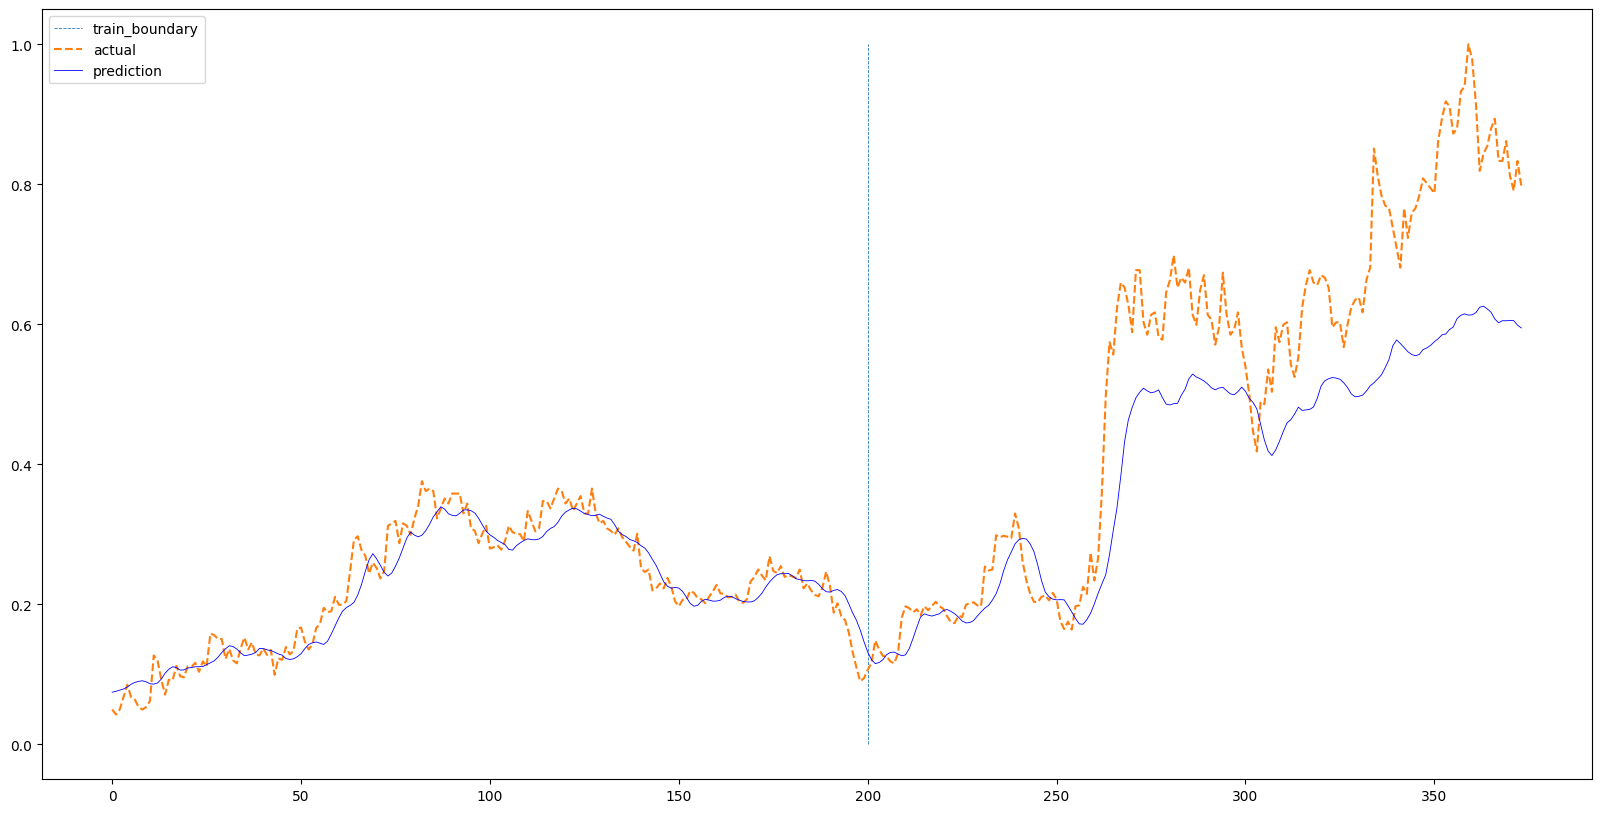

In [14]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

- 대략적인 상승 추세 잡아냄
- 떨어지는 지점 값 예측함

In [15]:
# LSTM
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0565
[epoch: 10] loss: 0.0037
[epoch: 20] loss: 0.0008
[epoch: 30] loss: 0.0008
[epoch: 40] loss: 0.0009


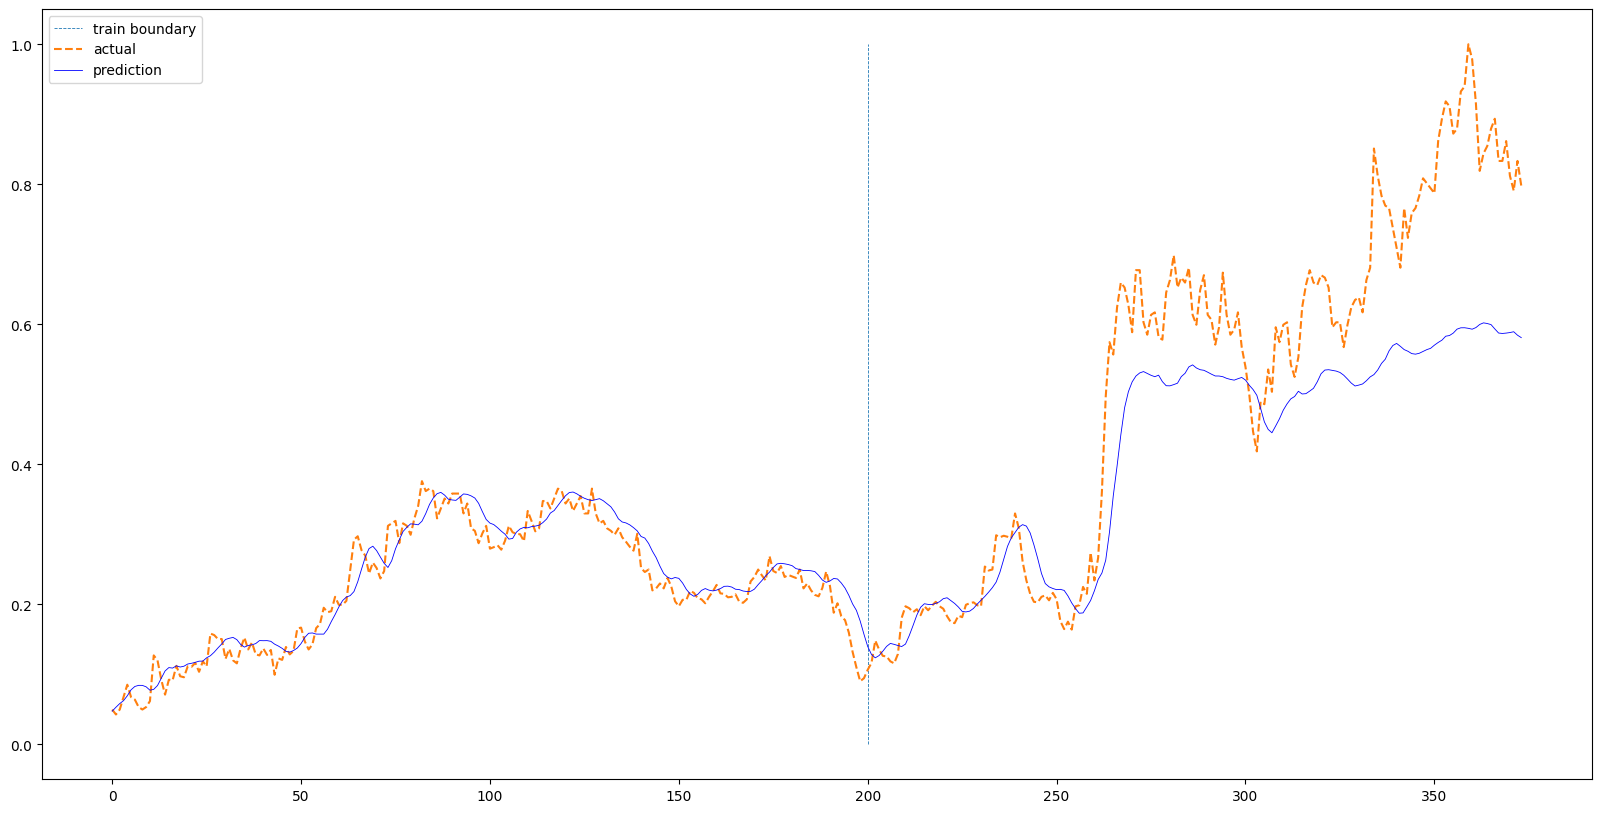

In [16]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

- RNN보다는 상승 추세 예측 약함
- 디테일한 상승 및 하강 추세에도 약한듯